<a href="https://colab.research.google.com/github/cryssoga/DSWP/blob/master/Li%C3%A7%C3%A3o/NB15_00_CreditCard_RandomForest_CHURN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Carregando as bibliotecas:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Lendo arquivo csv:
url = 'https://raw.githubusercontent.com/cryssoga/DSWP/master/Dataframes/creditcard.csv'
df_cc = pd.read_csv(url)

In [ ]:
df_cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
# Dimensões do dataframe:
df_cc.shape

(12842, 31)

In [ ]:
# Nome das 31 colunas do dataframe:
df_cc.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
# Normalizar nomes das colunas:
df_cc.columns = df_cc.columns.str.lower()

In [ ]:
df_cc.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

In [ ]:
# Verificando NaN
df_cc.isna().sum()

time      0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       1
v11       1
v12       1
v13       1
v14       1
v15       1
v16       1
v17       1
v18       1
v19       1
v20       1
v21       1
v22       1
v23       1
v24       1
v25       1
v26       1
v27       1
v28       1
amount    1
class     1
dtype: int64

In [ ]:
# Eliminando única linha com NaN:
df_cc.dropna(inplace=True)

In [ ]:
df_cc.isna().sum()

time      0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       0
v11       0
v12       0
v13       0
v14       0
v15       0
v16       0
v17       0
v18       0
v19       0
v20       0
v21       0
v22       0
v23       0
v24       0
v25       0
v26       0
v27       0
v28       0
amount    0
class     0
dtype: int64

In [ ]:
# NaN eliminado, df tinha 12842 linhas e agora tem 12841 linhas
df_cc.shape

(12841, 31)

In [ ]:
# Definindo variáveis globais:
i_CV = 10     # número de Cross-Validations (CV)
i_Seed = 20111974
f_Test_Size = 0.3   # Hold-Out: 30% teste, 70% treinamento

from sklearn.model_selection import train_test_split    # para definir amostra de treinamento e de teste
from sklearn.model_selection import cross_val_score     # para CV (Cross-Validation)
from sklearn.model_selection import GridSearchCV        # para GridSearchCV (otimizar os parâmetros dos modelos preditivos)
from time import time                                   # requerida na função gridsearchcv
from sklearn.ensemble import RandomForestClassifier     # para o RandomForestClassifier
from sklearn.metrics import confusion_matrix            # para plotar a confusion matrix

In [ ]:
# Carregando os dados para df_X e df_y:
df_cc.columns
df_cc.columns[0:30]
df_cc.columns[30]

df_X = df_cc.iloc[:,1:30]         # primeira coluna é 'time' e não entra no df_X
df_y = df_cc.iloc[:,30]

In [ ]:
# Definindo amostras de treinamento e teste:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = f_Test_Size, random_state = i_Seed)

In [ ]:
# Função para Cross-Validation:

def funcao_cross_val_score(modelo, X_treinamento, y_treinamento, CV):
    
    #versão com cross_val_score:
    a_scores_CV = cross_val_score(modelo, X_treinamento, y_treinamento, cv = CV)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    return a_scores_CV  # é um array com os scores a cada iteração do CV


In [ ]:
# Função para Confusion Matrix:

def mostra_confusion_matrix(cf, 
                            group_names = None, 
                            categories = 'auto', 
                            count = True, 
                            percent = True, 
                            cbar = True, 
                            xyticks = False, 
                            xyplotlabels = True, 
                            sum_stats = True, 
                            figsize = (8, 8), 
                            cmap = 'Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [ ]:
# função para GridSearchCV:

def GridSearchOptimizer(modelo, ml_Opt, d_Parametros, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas):
    ml_GridSearchCV = GridSearchCV(modelo, d_Parametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_treinamento, y_treinamento)
    tempo_elapsed = time()-start
    #print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Parâmetros que otimizam a classificação:
    print(f'\nParametros otimizados: {ml_GridSearchCV.best_params_}')
    
    if ml_Opt == 'ml_DT2':
        print(f'\nDecisionTreeClassifier *********************************************************************************************************')
        ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_RF2':
        print(f'\nRandomForestClassifier *********************************************************************************************************')
        ml_Opt = RandomForestClassifier(bootstrap= ml_GridSearchCV.best_params_['bootstrap'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_features= ml_GridSearchCV.best_params_['max_features'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_split'],
                                        n_estimators= ml_GridSearchCV.best_params_['n_estimators'],
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_AB2':
        print(f'\nAdaBoostClassifier *********************************************************************************************************')
        ml_Opt = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator=RandomForestClassifier(bootstrap = False, 
                                                                          max_depth = 10, 
                                                                          max_features = 'auto', 
                                                                          min_samples_leaf = 1, 
                                                                          min_samples_split = 2, 
                                                                          n_estimators = 400), 
                                    learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                    n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                    random_state = i_Seed)
        
    elif ml_Opt == 'ml_GB2':
        print(f'\nGradientBoostingClassifier *********************************************************************************************************')
        ml_Opt = GradientBoostingClassifier(learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                            n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                            max_depth = ml_GridSearchCV.best_params_['max_depth'], 
                                            min_samples_split = ml_GridSearchCV.best_params_['min_samples_split'], 
                                            min_samples_leaf = ml_GridSearchCV.best_params_['min_samples_leaf'], 
                                            max_features = ml_GridSearchCV.best_params_['max_features'])
        
    elif ml_Opt == 'ml_XGB2':
        print(f'\nXGBoostingClassifier *********************************************************************************************************')
        ml_Opt = XGBoostingClassifier(learning_rate= ml_GridSearchCV.best_params_['learning_rate'], 
                                      max_depth= ml_GridSearchCV.best_params_['max_depth'], 
                                      colsample_bytree= ml_GridSearchCV.best_params_['colsample_bytree'], 
                                      subsample= ml_GridSearchCV.best_params_['subsample'], 
                                      gamma= ml_GridSearchCV.best_params_['gamma'], 
                                      min_child_weight= ml_GridSearchCV.best_params_['min_child_weight'])
        
    # Treina novamente usando os parametros otimizados...
    ml_Opt.fit(X_treinamento, y_treinamento)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = funcao_cross_val_score(ml_Opt, X_treinamento, y_treinamento, i_CV)

    # Faz predições com os parametros otimizados...
    y_pred = ml_Opt.predict(X_teste)
  
    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(l_colunas, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_teste, y_pred)
    cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
    cf_categories = ['Zero', 'One']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_


In [ ]:
# Visualizar os resultados:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

np.set_printoptions(suppress=True)

dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = l_colunas, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())

RANDOM FORESTER

In [ ]:
X_treinamento.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount
2703,-0.865219,0.559533,1.827937,1.916530,-1.340151,0.422785,0.368870,0.492706,0.138602,-0.914458,-1.074315,1.467963,1.103796,-0.697232,-1.886390,-1.344720,1.046415,-0.768432,1.459743,0.290028,-0.141669,-0.274566,0.457549,0.742448,-0.423104,-0.530132,0.077366,0.136213,165.80
4865,1.314683,0.188203,-1.150419,-0.279736,2.213941,3.228529,-0.598057,0.724365,1.210910,-0.587911,1.079128,-2.535077,1.651240,1.321689,0.562524,0.783531,0.236825,0.439817,-0.027986,-0.010920,-0.493294,-1.334642,0.107215,0.885085,0.346663,0.072047,-0.048533,0.017192,1.79
2713,-0.608293,0.534703,2.437976,0.012105,-0.305314,0.360343,0.003408,0.301774,-0.062306,-0.596140,0.576833,0.912134,0.393844,-0.409473,-0.722193,0.301456,-0.532316,0.501936,0.590008,0.051579,0.029949,0.204280,-0.217892,0.055265,-0.100031,0.296647,0.091340,0.098176,11.50
3349,1.167954,0.125881,0.879225,0.786664,-0.869120,-1.111867,-0.079887,-0.243691,0.073567,-0.089091,0.296125,0.928709,1.177466,-0.059376,1.024018,0.175258,-0.352101,-0.301933,-0.601417,0.003294,0.201747,0.641861,-0.059488,1.002315,0.426409,0.449189,-0.014699,0.027996,26.00
720,1.183728,0.143447,0.238718,1.316873,-0.030196,0.012157,0.022382,0.042439,0.409277,-0.107349,-0.964158,0.080510,-0.689019,0.168558,0.000919,-0.588669,0.168420,-0.783959,-0.228904,-0.212156,-0.130755,-0.175158,-0.101670,-0.282291,0.689079,-0.288746,0.034764,0.011592,11.46


In [ ]:
y_treinamento.head()

2703    0.0
4865    0.0
2713    0.0
3349    0.0
720     0.0
Name: class, dtype: float64

In [ ]:
# RandomForestClassifier

# Instancia...
ml_RF= RandomForestClassifier(n_estimators=100, min_samples_split= 2, max_features="auto", random_state= i_Seed)

# Treina...
ml_RF.fit(X_treinamento, y_treinamento)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20111974,
                       verbose=0, warm_start=False)

In [ ]:
ml_RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20111974,
                       verbose=0, warm_start=False)

In [ ]:
# Chama a função do Cross-Validation:

a_scores_CV = funcao_cross_val_score(ml_RF, X_treinamento, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 99.92999999999999
std médio das Acurácias calculadas pelo CV: 0.06999999999999999


In [ ]:
print(f'Acurácias: {a_scores_CV}')

In [ ]:
# Faz predições...
y_pred = ml_RF.predict(X_teste)

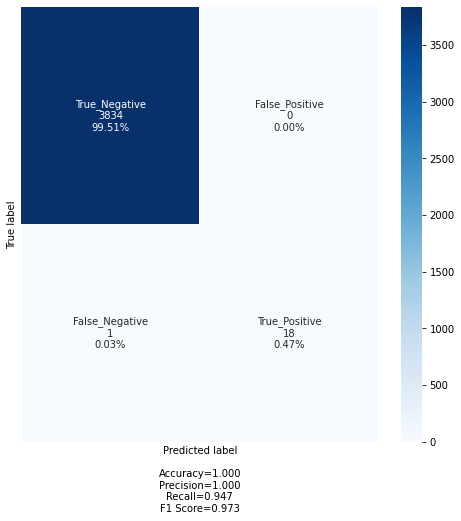

In [ ]:
# Confusion Matrix
# chama a função confusion matrix:

cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative','False_Positive','False_Negative','True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [ ]:
# Dicionário de parâmetros para o parameter tunning.
d_hiperparametros_RF= {'bootstrap': [True, False],
                  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
l_colunas = df_X.columns

In [ ]:
# Invoca a função do GridSearch
ml_RF2, best_params = GridSearchOptimizer(ml_RF, 'ml_RF2', d_hiperparametros_RF, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

KeyboardInterrupt: ignored

In [ ]:
# Visualizar os resultados:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

np.set_printoptions(suppress=True)

dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = l_colunas, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())